# Introduction/Abstract

The purpose of this project is to try and create a linear model for Housing Prices in King County. With this linear model we will be able to predict future housing prices. The features that are going to be used in the linear model will be discovered through EDA of an existing housing data set.

## Main questions

1. Can we actually use a linear model to predict housing prices?
2. What features are important for evaluating a house?
3. How accurate can we get the model to be?

# Packages Needed/Setting Global Variables

These are the packages needed and also the global functions needed for this notebook.

## Packages

In [103]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.stats.api as sms




pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Functions

In [104]:
def Decade(List):
    decade_list=[]
    oldest = List.min()
    i=0
    for x in List:
        i += 1
        while len(decade_list) < i:
            if (x >= oldest) & (x < (oldest+10)):
                decade_list.append('{}-{}'.format(oldest,(oldest+10)))
            oldest += 10
        oldest = List.min()
    return decade_list

In [105]:
def zoningLat(List):
    lowest = List.min()
    highest = List.max()
    distance = highest - lowest
    distance = math.ceil(distance*69)
    zones = []
    for entry in List:
        for zone in list(range(1,distance+1)):
            if ((lowest+(zone-1)/69) <= entry) &(entry < (lowest + zone/69)):
                zones.append(zone)
    return zones

def zoningLong(List):
    lowest = List.min()
    highest = List.max()
    distance = highest-lowest
    distance = math.ceil(distance*54.6)
    zones = []
    for entry in List:
        for zone in list(range(1,distance+1)):
            if ((lowest+(zone-1)/54.6) <= entry) & (entry < (lowest + zone/54.6)):
                zones.append(zone)
    return zones

In [106]:
def FromCenter(Lat,Long):
    Latdiff=[]
    Longdiff=[]
    for LatEntry in Lat:
        Latdiff.append(47.6050-LatEntry)
    for LongEntry in Long:
        Longdiff.append(-122.3344-LongEntry)
    Latdiff = [(x*69)**2 for x in Latdiff]
    Longdiff = [(x*54.6)**2 for x in Longdiff]
    distance = [np.sqrt(a + b) for a, b in zip(Latdiff, Longdiff)]
    return distance

In [107]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            #included.remove(worst_feature)
            del included[worst_feature]
            
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [108]:
def ModelCheck(X_train, y_train, X_test, y_test):
    
    X_train_int = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_int).fit()
 
    residuals = model.resid
    
    fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,figsize=(8,10))
    
    ax1.set_title('Homoscedasticity Check')
    ax1.set_ylabel('Residuals')
    ax1.set_xlabel('Price')
    ax1.axhline(y=0, color='r', linestyle='-')
    ax2.set_title('QQ plot')

    ax1.scatter(x=y_train,y=residuals);
    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=ax2);

    fig.show()
    
    names = ['Lagrange multiplier statistic', 'p-value',
            'f-value', 'f p-value']
    bp_test = sms.het_breuschpagan(residuals, model.model.exog)
    print(dict(zip(names,bp_test)))
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)

    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    print('Train Mean Squarred Error:', train_mse)
    print('Test Mean Squarred Error:', test_mse)
    print('Train Mean Error:',np.sqrt(train_mse))
    print('Test Mean Error:',np.sqrt(test_mse))
    print('Difference in Mean Error:', np.sqrt(test_mse)-np.sqrt(train_mse))
    
    return model.summary()

In [109]:
def LoggedModelCheck(X_train, y_train, X_test, y_test):
    
    X_train_int = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_int).fit()
 
    residuals = model.resid
    
    fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,figsize=(8,10))
    
    ax1.set_title('Homoscedasticity Check')
    ax1.set_ylabel('Residuals')
    ax1.set_xlabel('Price')
    ax1.axhline(y=0, color='r', linestyle='-')
    ax2.set_title('QQ plot')

    ax1.scatter(x=y_train,y=residuals);
    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=ax2);

    fig.show()
    
    names = ['Lagrange multiplier statistic', 'p-value',
            'f-value', 'f p-value']
    bp_test = sms.het_breuschpagan(residuals, model.model.exog)
    print(dict(zip(names,bp_test)))
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)

    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    y_hat_train = np.exp(y_hat_train)
    y_hat_test = np.exp(y_hat_test)
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    print('Train Mean Squarred Error:', train_mse)
    print('Test Mean Squarred Error:', test_mse)
    print('Train Mean Error:',np.sqrt(train_mse))
    print('Test Mean Error:',np.sqrt(test_mse))
    print('Difference in Mean Error:', np.sqrt(test_mse)-np.sqrt(train_mse))
    
    return model.summary()

# EDA

## Import and Clean the Data

In [110]:
# Import the dataset
df = pd.read_csv('kc_house_data.csv')

#Dropping id column
df = df.drop(['id'],axis=1)

#Dropping outliers using transformed std deviation of 2.5 (99%)
#Logging price to create a normal distribution and then using that std to drop outliers
df['log_price'] = df['price'].map(lambda x: np.log(x))
maximum_log_price= df.log_price.mean() + (2.5*df.log_price.std())
minimum_log_price = df.log_price.mean() - (2.5*df.log_price.std())
df = df[(df['log_price'] >= minimum_log_price ) & 
            (df['log_price'] <= maximum_log_price)]
df = df.drop(['log_price'],axis=1)

# Creating a new column for the year sold, dropping origianl date
df['year_sold'] = df.date.apply(lambda x: x[-4:]).astype(int)
df = df.drop(['date'], axis=1)

# Changing bedroom number for outlier, I think it was a typo of hitting 3 twice
# based off of the sqft
df.at[15856, 'bedrooms'] = 3

# Replacing NaN values in 'waterfront' with 0
df['waterfront'] = df['waterfront'].fillna(0)

# Replacing NaN values in view with the median/mode value which is 0 (63 entries)
# 0 means house was not viewed
df['view'] = df['view'].fillna(0)

# Replacing ? in sqft_basement and converting to float
df['sqft_basement'] = df['sqft_basement'].replace('?',0).astype(float)

# yr_renovated and renovated columns
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df['Renovated'] = df['yr_renovated'] > 0
df['Renovated'] = df['Renovated'].astype(int)
df['yr_renovated'] = df['yr_renovated'].replace(0,df['yr_built'])

#Adding column for age when sold
df['Age_When_Sold'] = df['year_sold'] - df['yr_built']

#Adding column for years since renovation when sold and dropping yr_renovated
df['Age_Since_Renovation'] = df['year_sold'] - df['yr_renovated']

#Adding interaction variable Renovated*Age since renovation
df['Renovated*Age'] = df['Renovated'] * df['Age_Since_Renovation']

#Adding zones for Lat and Long
df['Lat_Zones'] = zoningLat(df['lat'])
df['Long_Zones'] = zoningLong(df['long'])
df['Lat_Zones'] = df['Lat_Zones'].astype(str)
df['Long_Zones'] = df['Long_Zones'].astype(str)
df['DistanceFromCenterOfSeattle'] = FromCenter(df['lat'],df['long'])
#df['Zones'] = df['Lat_Zones'] + 'x' + df['Long_Zones']
df = df.drop(['lat','long','Long_Zones','Lat_Zones'],axis=1)

#Grouping year built by decade
df['yr_built'] = Decade(df.yr_built)

#Dropping 'year_sold',only seems to have two years, not valuable category
df = df.drop(['year_sold'], axis=1)

## Linearity and preprocessing

For a linear model the individual features has to meet a linearity assumption. The linearity assumption means that the features have to have a direct linear relationship with the dependent variable (price).

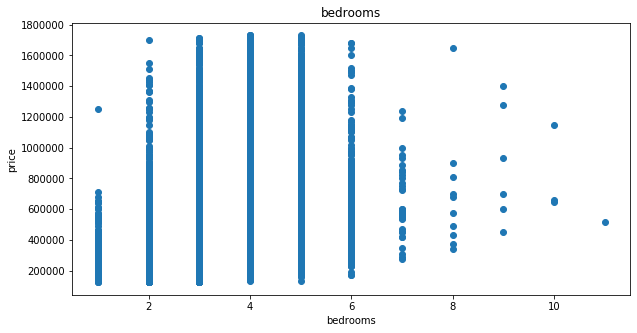

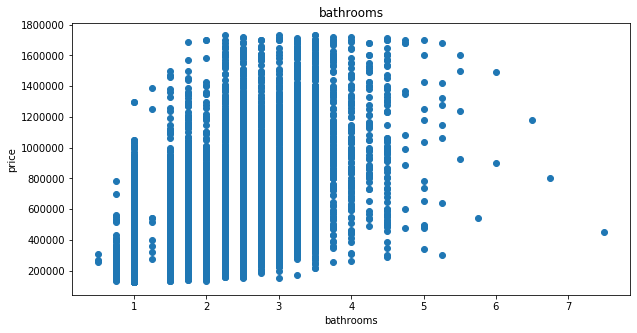

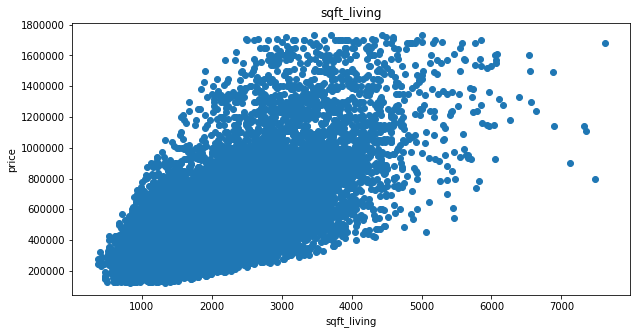

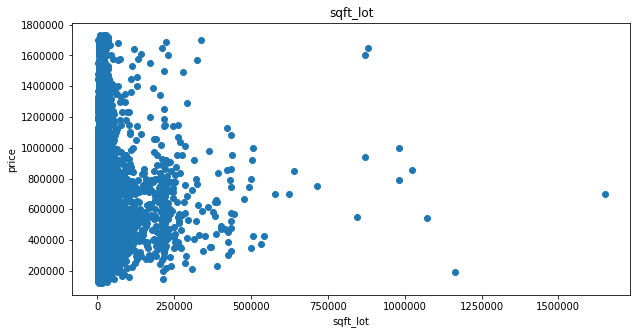

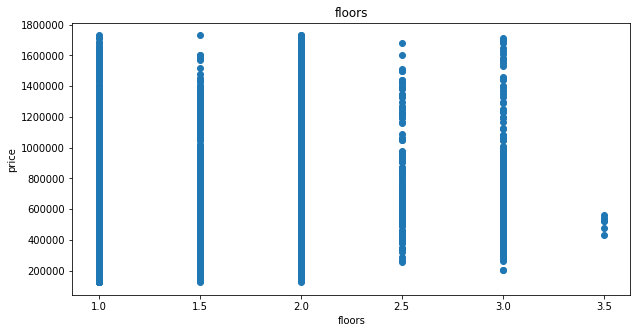

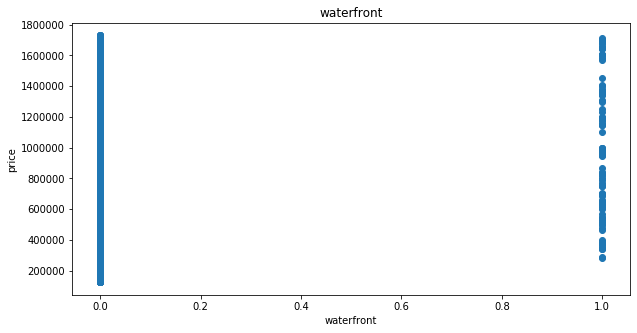

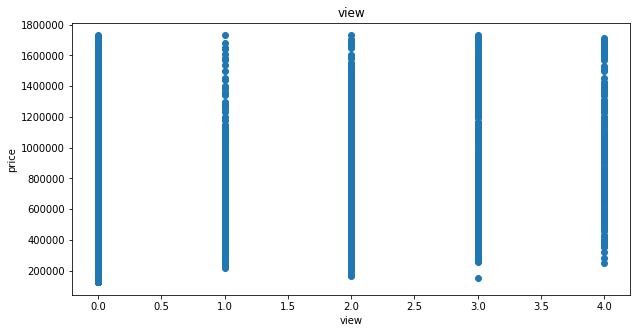

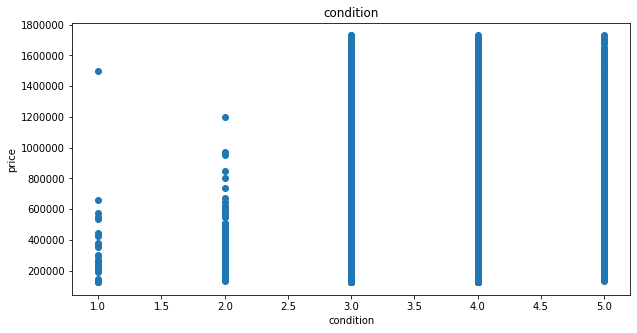

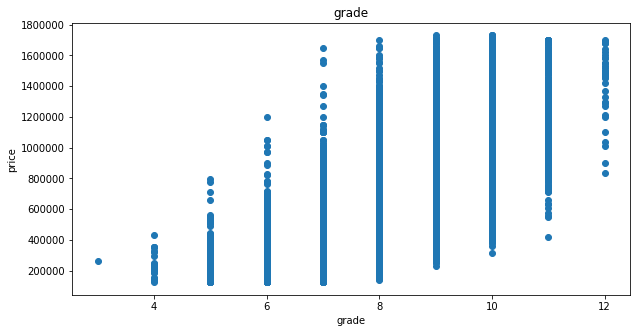

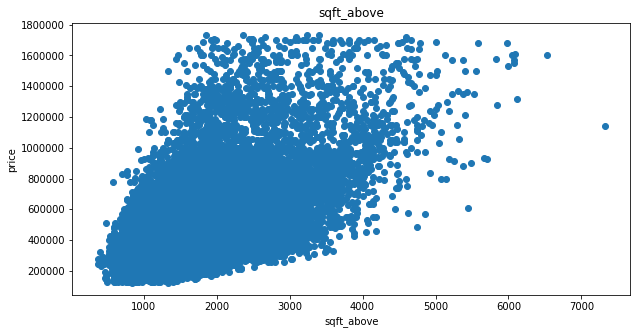

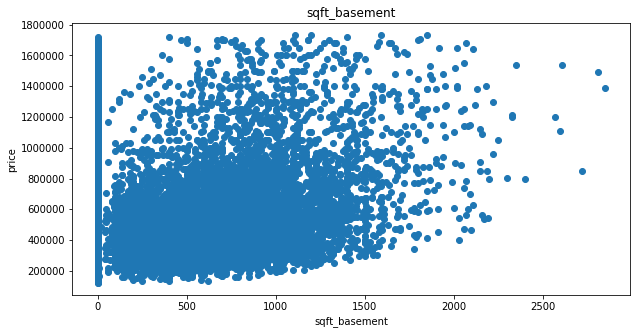

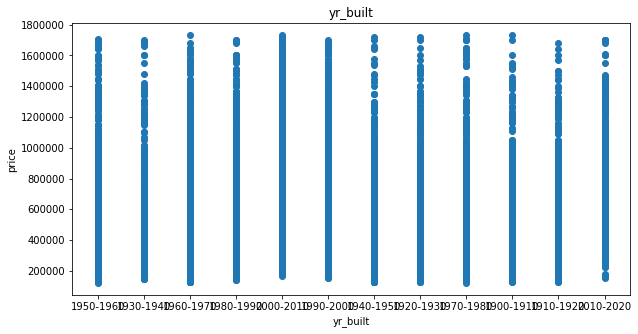

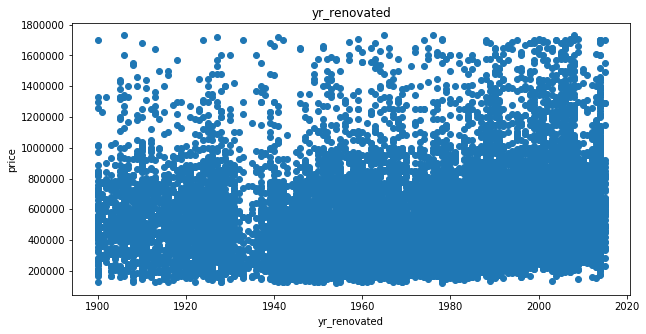

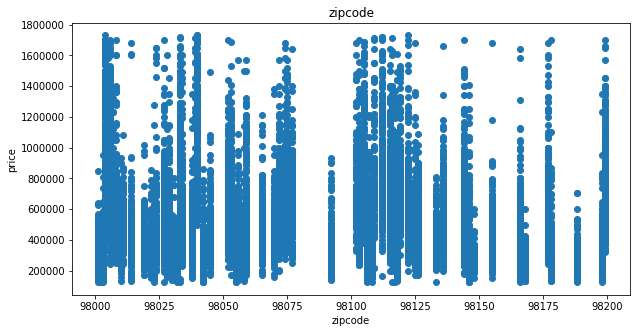

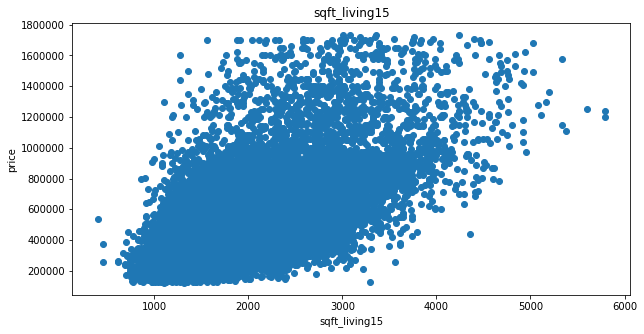

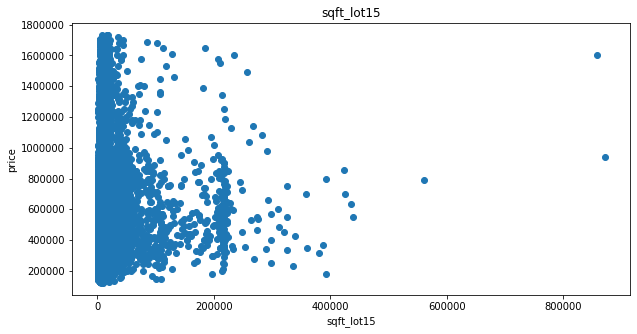

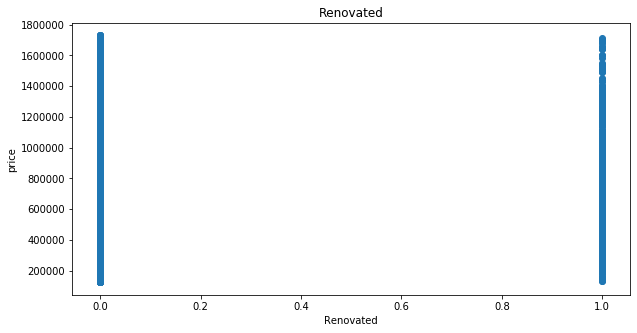

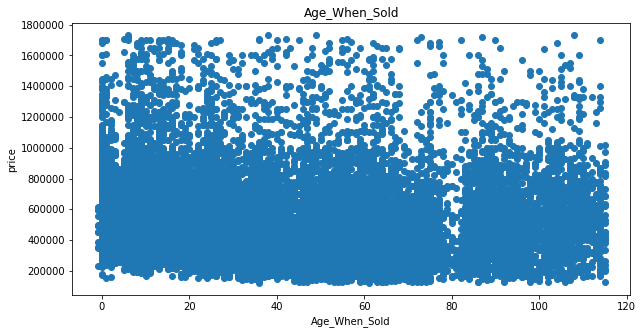

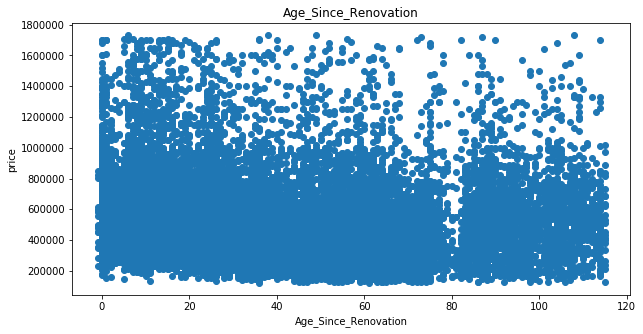

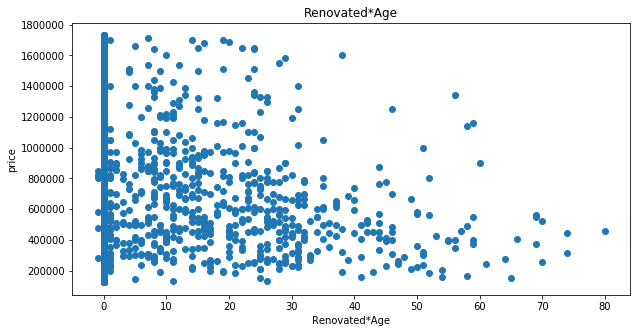

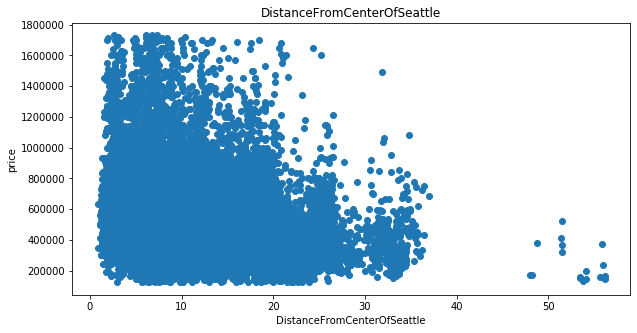

In [111]:
col = list(df.columns)
col.remove('price')
for column in col:
    plt.figure(figsize=(10,5))
    plt.scatter(x=df[column],y=df['price'])
    plt.xlabel(column)
    plt.ylabel('price')
    plt.title(column)
    plt.show()

In [112]:
df.groupby('floors').price.mean()

floors
1.0    434340.500332
1.5    543319.299417
2.0    600064.141948
2.5    784703.394161
3.0    558983.574751
3.5    511916.666667
Name: price, dtype: float64

In [113]:
df.groupby('bedrooms').price.mean()

bedrooms
1     331053.967568
2     404435.375415
3     456816.638880
4     597044.943172
5     678507.925877
6     673851.580392
7     658906.781250
8     694600.000000
9     893999.833333
10    820000.000000
11    520000.000000
Name: price, dtype: float64

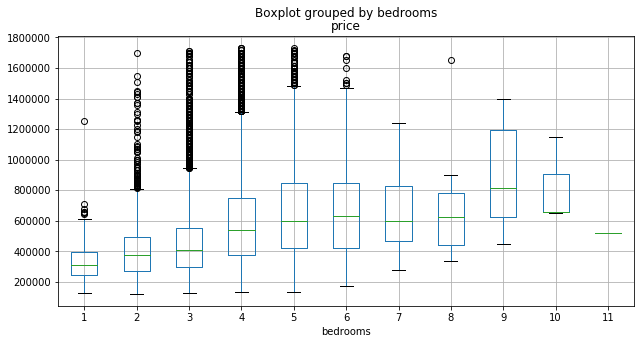

In [114]:
df.boxplot(column='price',by='bedrooms',figsize=(10,5));

In [115]:
df[df['bedrooms']>9]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,Renovated,Age_When_Sold,Age_Since_Renovation,Renovated*Age,DistanceFromCenterOfSeattle
8748,520000.0,11,3.00,3000,4960,2.0,0.0,0.0,3,7,2400,600.0,1910-1920,1999.0,98106,1420,4960,1,96,15.0,15.0,3.724195
13301,1150000.0,10,5.25,4590,10920,1.0,0.0,2.0,3,9,2500,2090.0,2000-2010,2008.0,98004,2730,10400,0,6,6.0,0.0,12.158580
15147,650000.0,10,2.00,3610,11914,2.0,0.0,0.0,4,7,3010,600.0,1950-1960,1958.0,98006,2040,11914,0,56,56.0,0.0,9.022925
19239,660000.0,10,3.00,2920,3745,2.0,0.0,0.0,4,7,1860,1060.0,1910-1920,1913.0,98105,1810,3745,0,101,101.0,0.0,4.112360


In [116]:
df.groupby('yr_built').price.mean()

yr_built
1900-1910    590486.476038
1910-1920    550961.313776
1920-1930    567119.279966
1930-1940    542317.136634
1940-1950    436813.529686
1950-1960    464458.543722
1960-1970    442818.585301
1970-1980    482108.517897
1980-1990    506697.418109
1990-2000    548268.407205
2000-2010    565220.889245
2010-2020    590593.296603
Name: price, dtype: float64

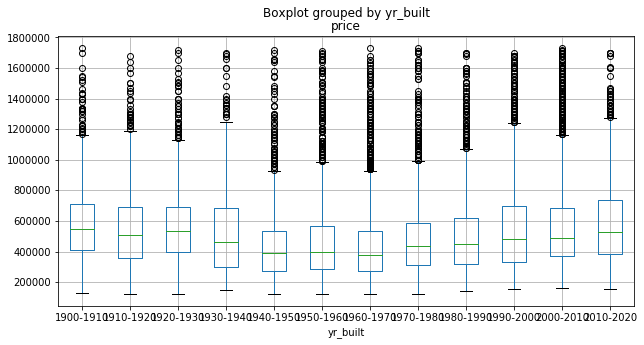

In [117]:
df.boxplot(column='price',by='yr_built',figsize=(10,5));

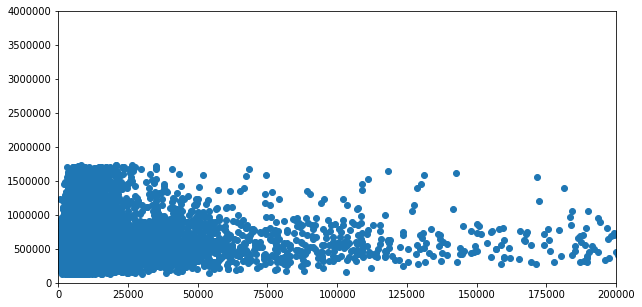

In [118]:
plt.figure(figsize=(10,5))
plt.xlim((-.05,200000))
plt.ylim((-.05,4000000))
plt.scatter(x=df['sqft_lot'],y=df['price'])
plt.show()

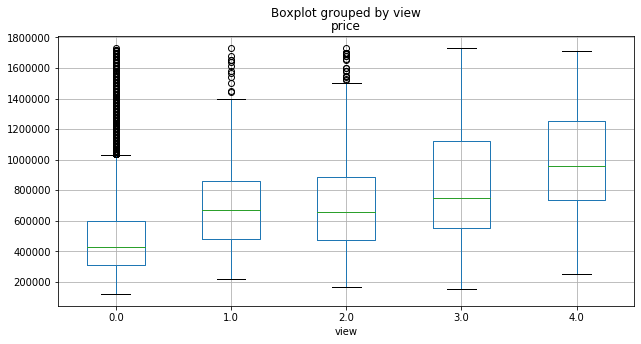

In [119]:
df.boxplot(column='price',by='view',figsize=(10,5));

In [120]:
df.groupby('view').price.mean()

view
0.0    485979.942913
1.0    714300.574194
2.0    717012.633588
3.0    836975.826087
4.0    998578.722944
Name: price, dtype: float64

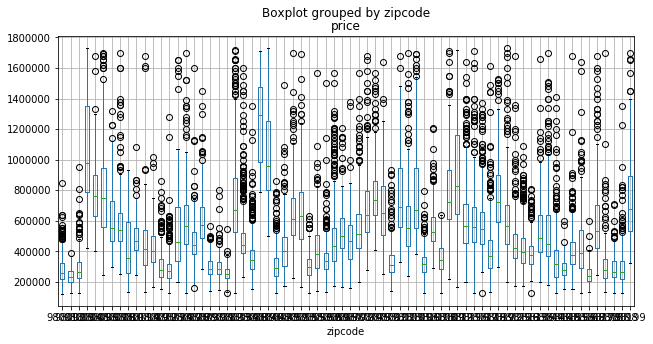

In [121]:
df.boxplot(column='price',by='zipcode',figsize=(10,5));

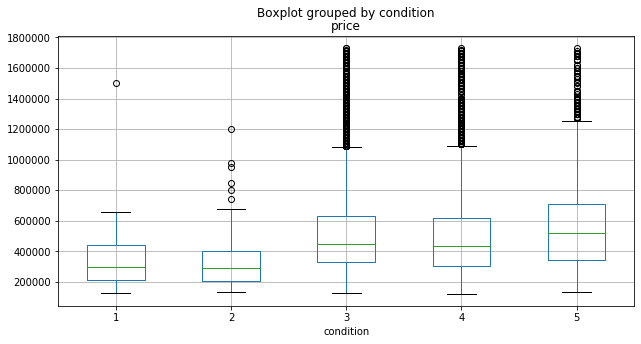

In [122]:
df.boxplot(column='price',by='condition',figsize=(10,5));

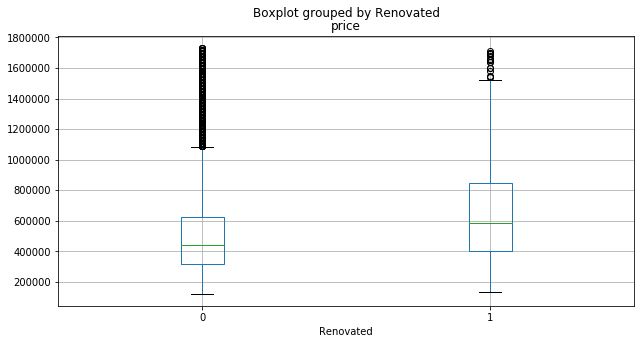

In [123]:
df.boxplot(column='price',by='Renovated',figsize=(10,5));

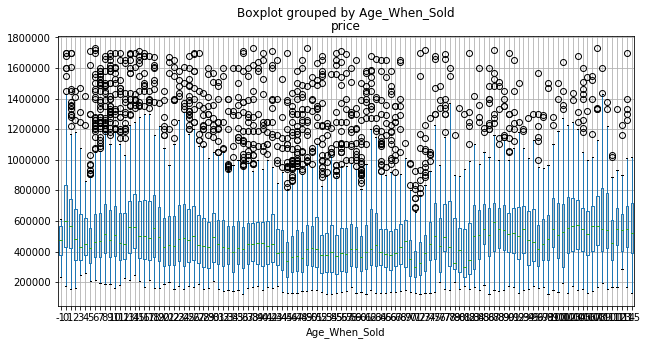

In [124]:
df.boxplot(column='price',by='Age_When_Sold',figsize=(10,5));

Looking at linearity. It looks like the features that could have strong linear relationships are:
1. bathrooms
2. sqft_living
3. sqft_above
4. sqft_living15
5. grade

Ones that seem like they could have a mild linear relationship are:

1. bedrooms
2. DistanceFromSeattle
3. condition
4. views


In [125]:
# These are the variables that are going to be dropped
# for not meeting the linearity assumption

non_linearity = ['sqft_lot','yr_built','yr_renovated','sqft_lot15',
                 'Age_When_Sold','Age_Since_Renovation','Renovated*Age','zipcode',
                 'sqft_basement']

df_linear = df.drop(non_linearity,axis=1)

In [126]:
#Creating Dummie Variables double check this list
#Taking out bedrooms, bathrooms, view, condition
dummy_list = ['Renovated','waterfront'] #Trying grade as a continuous variable, Also try without zipcode
dum=df_linear[dummy_list].astype('category')
dummies = pd.get_dummies(dum[dummy_list],prefix=dummy_list,drop_first=True)
df_preprocessed = df_linear.drop(dummy_list, axis=1)
df_preprocessed = pd.concat([df_preprocessed,dummies],axis=1)

# Modeling

## First Model

First basic model, to look at what we're working with.

In [127]:
#Omitting zones for now, too much data to process
y = df_preprocessed['price']
X = df_preprocessed.drop(['price'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

{'Lagrange multiplier statistic': 1231.896450651193, 'p-value': 2.3396904396226743e-256, 'f-value': 110.619397432874, 'f p-value': 2.297772292670759e-266}
Train Mean Squarred Error: 22260538975.493393
Test Mean Squarred Error: 21408600602.147602
Train Mean Error: 149199.66144563933
Test Mean Error: 146316.78168326285
Difference in Mean Error: -2882.879762376484


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     3138.
Date:                Sun, 01 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:43:53   Log-Likelihood:            -2.2596e+05
No. Observations:               16949   AIC:                         4.520e+05
Df Residuals:                   16936   BIC:                         4.521e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -3.724e+05   1.36e+04    -27.454      0.000   -3.99e+05   -3.46e+05
bedrooms                    -1.523e+04   1661.026     -9.167      0.000   -1.85e+04    -1.2e+04
bathrooms                    6808.2510   2601.707      2.617      0.009    1708.635    1.19e+04
sqft_living                    87.4991      3.776     23.175      0.000      80.099      94.900
floors                      -1.073e+04   2991.192     -3.587      0.000   -1.66e+04   -4865.217
view                         3.735e+04   1789.831     20.868      0.000    3.38e+04    4.09e+04
condition                     4.55e+04   1857.853     24.491      0.000    4.19e+04    4.91e+04
grade                        7.257e+04   1783.829     40.683      0.000    6.91e+04    7.61e+04
sqft_above                     38.7489      3.768     10.284      0.000      31.363      46.135
sqft_living15                  71.6327      2.924     24.495      0.000      65.901      77.365
DistanceFromCenterOfSeattle -1.374e+04    175.410    -78.310      0.000   -1.41e+04   -1.34e+04
Renovated_1                  9.874e+04   6396.088     15.437      0.000    8.62e+04    1.11e+05
waterfront_1.0               2.152e+05   1.89e+04     11.356      0.000    1.78e+05    2.52e+05
==============================================================================
Omnibus:                     2952.390   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8242.370
Skew:                           0.934   Prob(JB):                         0.00
Kurtosis:                       5.861   Cond. No.                     5.88e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

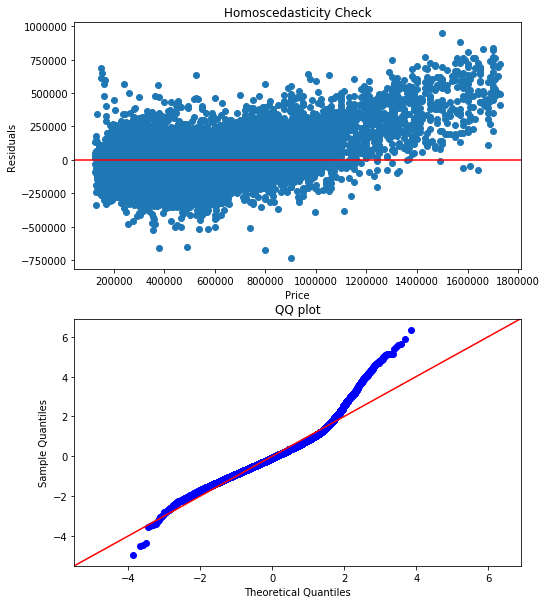

In [128]:
ModelCheck(X_train, y_train, X_test, y_test)

First Model Summary:

Adj.R-squared = 0.690

Average Error = ~150,000

## Looking at Multicollinearity

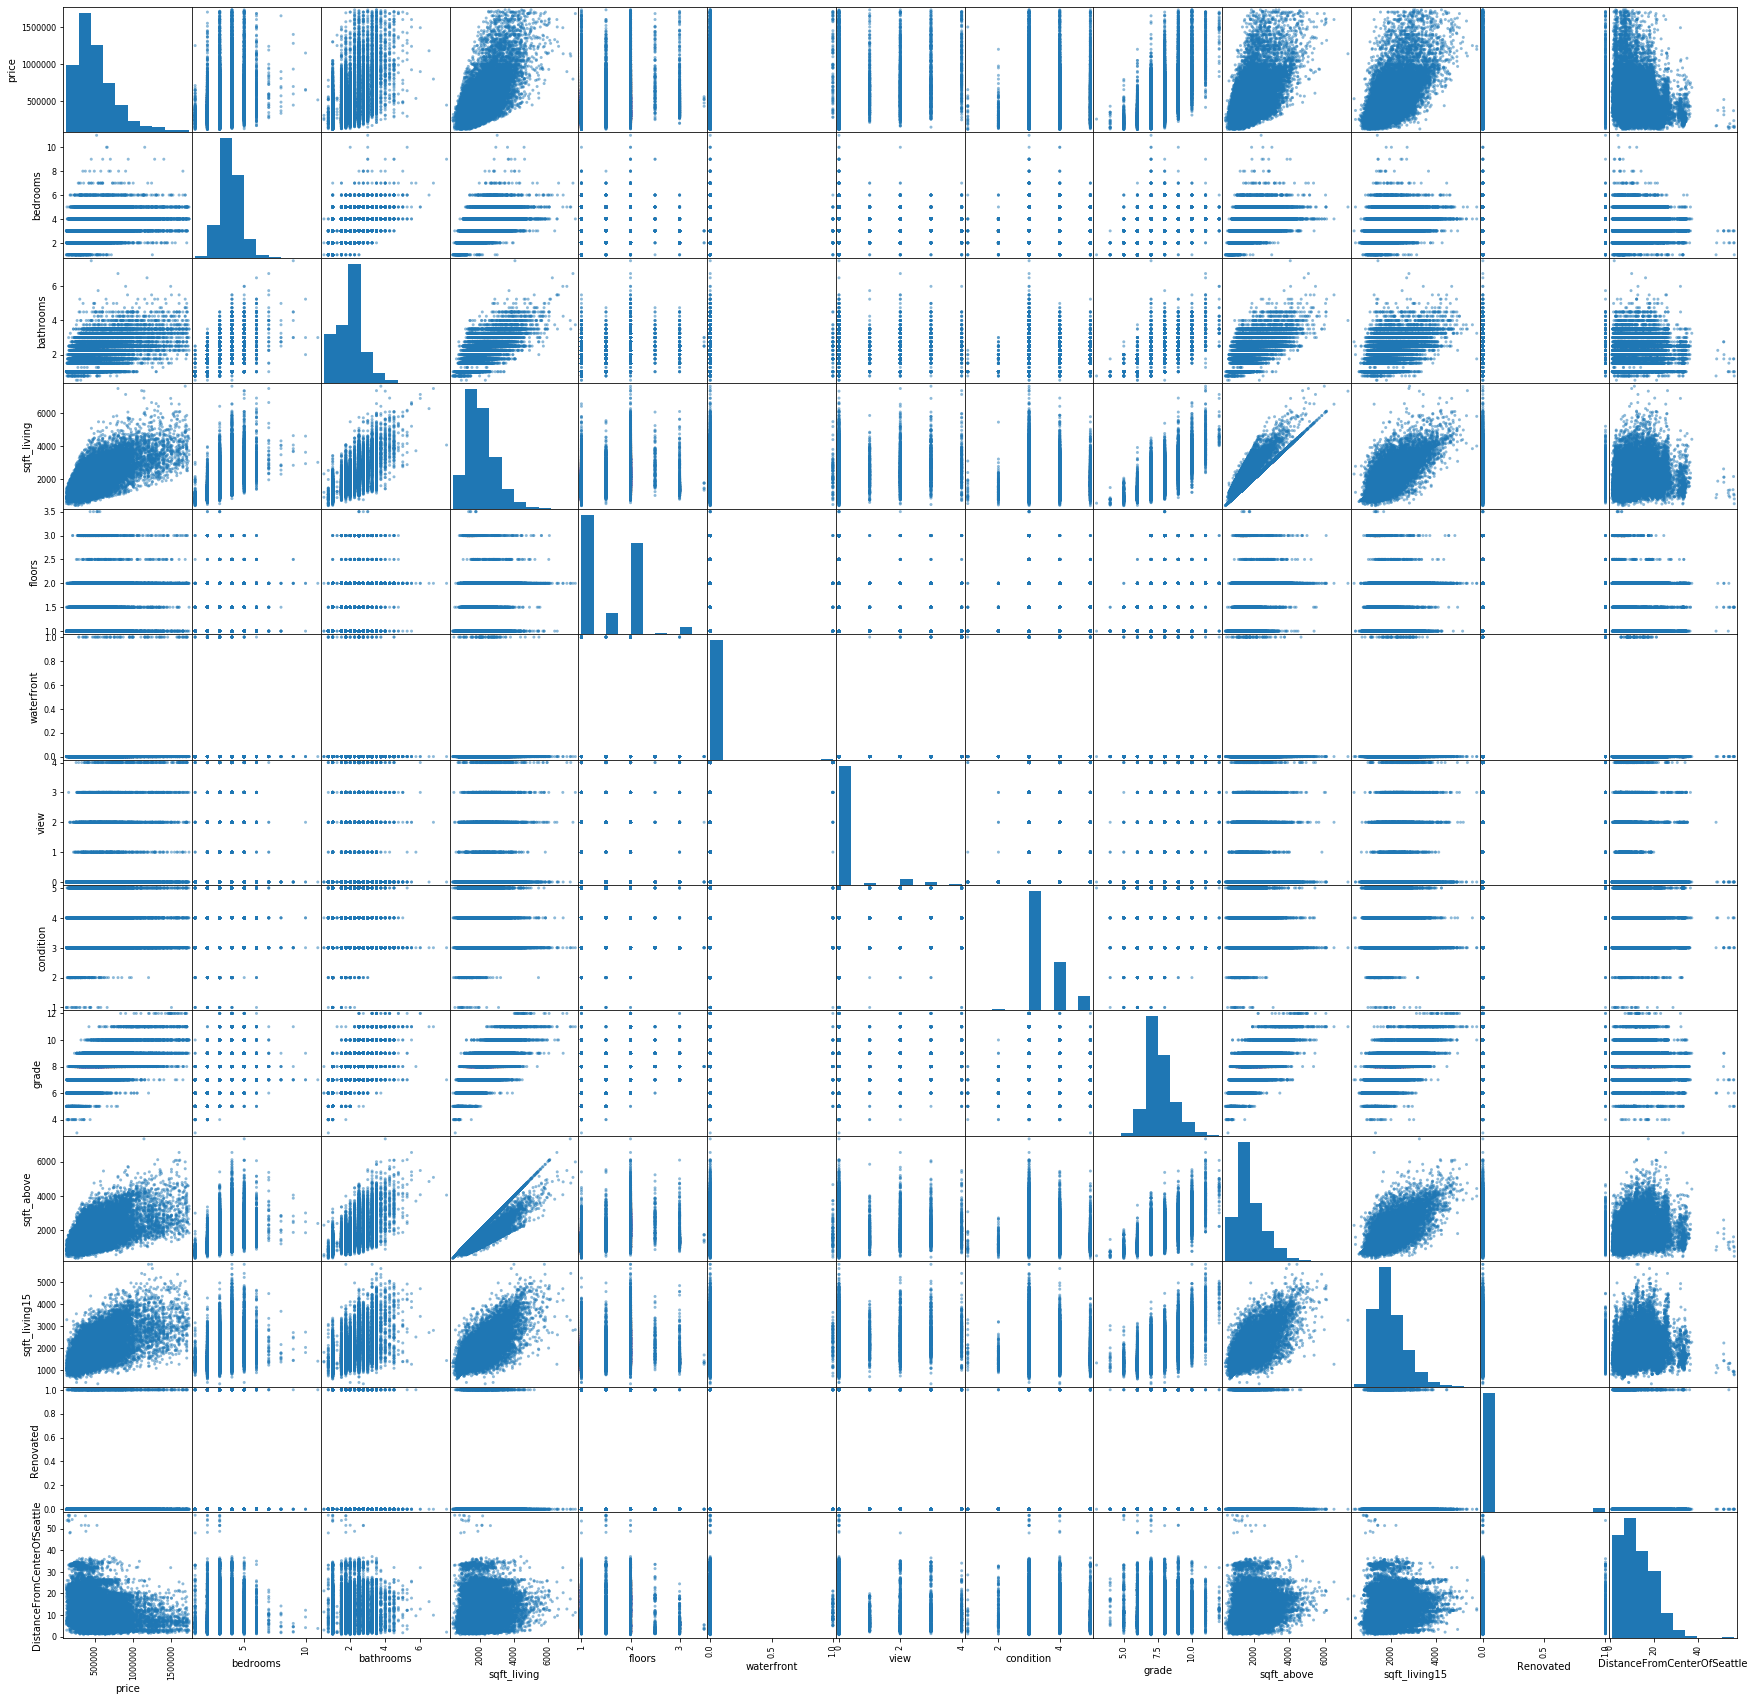

In [131]:
pd.plotting.scatter_matrix(df_linear,figsize  = [30, 30]);
plt.show()

In [132]:
test_corr=df_linear.corr().abs().stack().reset_index().sort_values(0, ascending=False)
test_corr['pairs'] = list(zip(test_corr.level_0, test_corr.level_1))
test_corr.set_index(['pairs'],inplace=True)
test_corr.drop(['level_0','level_1'],axis=1,inplace=True)
test_corr.columns = ['cc']
test_corr.drop_duplicates(inplace=True)
test_corr[(test_corr.cc >.75) & (test_corr.cc<1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.863839
"(sqft_living, sqft_living15)",0.752585


It looks like sqft_living is highly correlated with a bunch of variables. Let's take out sqft_above and sqft_living15 to see if this will fix the correlation.

In [133]:
df_linear = df_linear.drop(['sqft_living15','sqft_above'],axis=1)

In [134]:
test_corr2=df_linear.corr().abs().stack().reset_index().sort_values(0, ascending=False)
test_corr2['pairs'] = list(zip(test_corr2.level_0, test_corr2.level_1))
test_corr2.set_index(['pairs'],inplace=True)
test_corr2.drop(['level_0','level_1'],axis=1,inplace=True)
test_corr2.columns = ['cc']
test_corr2.drop_duplicates(inplace=True)
test_corr2[(test_corr2.cc >.75) & (test_corr2.cc<1)]

,cc
pairs,


In [135]:
#dropping sqft_living15,sqft_above from actual test/train set
X_train = X_train.drop(['sqft_living15','sqft_above'],axis=1)
X_test = X_test.drop(['sqft_living15','sqft_above'],axis=1)

## Second Model after removing collinearity

Second Model ran after taking out 2 features that were collinear.

{'Lagrange multiplier statistic': 1249.2098890468294, 'p-value': 3.487509060019896e-262, 'f-value': 134.7732482481612, 'f p-value': 1.6141767684198622e-272}
Train Mean Squarred Error: 23339779275.03981
Test Mean Squarred Error: 22246192671.446358
Train Mean Error: 152773.62100519778
Test Mean Error: 149151.57616145516
Difference in Mean Error: -3622.044843742624


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     3514.
Date:                Sun, 01 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:57:17   Log-Likelihood:            -2.2636e+05
No. Observations:               16949   AIC:                         4.528e+05
Df Residuals:                   16938   BIC:                         4.528e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        -4.15e+05   1.36e+04    -30.474      0.000   -4.42e+05   -3.88e+05
bedrooms                    -1.671e+04   1699.881     -9.831      0.000      -2e+04   -1.34e+04
bathrooms                   -1639.5318   2614.945     -0.627      0.531   -6765.095    3486.032
sqft_living                   144.3598      2.712     53.223      0.000     139.043     149.676
floors                       -987.5787   2686.669     -0.368      0.713   -6253.730    4278.573
view                         3.955e+04   1798.426     21.990      0.000     3.6e+04    4.31e+04
condition                    4.198e+04   1896.076     22.142      0.000    3.83e+04    4.57e+04
grade                        9.075e+04   1706.590     53.178      0.000    8.74e+04    9.41e+04
DistanceFromCenterOfSeattle -1.237e+04    167.737    -73.745      0.000   -1.27e+04    -1.2e+04
Renovated_1                  9.064e+04   6541.311     13.857      0.000    7.78e+04    1.03e+05
waterfront_1.0               2.117e+05   1.94e+04     10.916      0.000    1.74e+05     2.5e+05
==============================================================================
Omnibus:                     2871.741   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8334.885
Skew:                           0.898   Prob(JB):                         0.00
Kurtosis:                       5.929   Cond. No.                     3.66e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

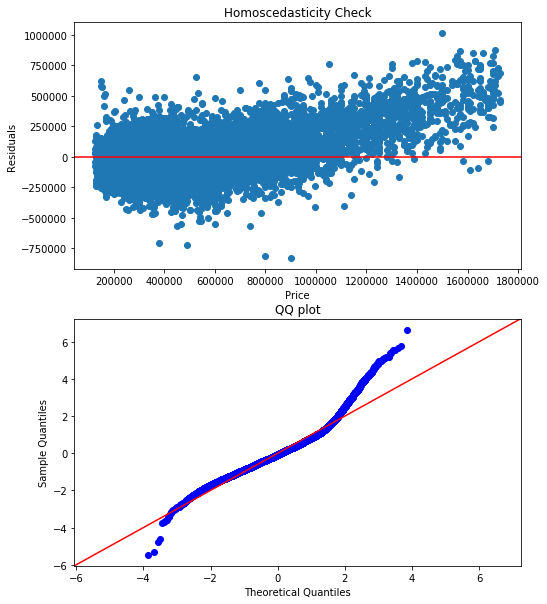

In [136]:
ModelCheck(X_train, y_train, X_test, y_test)

Second Model Summary:

Adj.R-squared = 0.675

Average Error = ~150,000

The Adj. R-Squared went down but that is to be expected since we reduced the number of features.


## Stepwise Selection of features

Now we can do stepwise selection to only select features with p-values below 0.05

In [137]:
len(X_train.columns)

10

In [138]:
results = stepwise_selection(X_train,y_train)

Add  view                           with p-value 0.0
Add  bedrooms                       with p-value 0.0


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  DistanceFromCenterOfSeattle    with p-value 0.0
Add  grade                          with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  condition                      with p-value 9.84088e-103
Add  Renovated_1                    with p-value 1.07204e-46
Add  waterfront_1.0                 with p-value 1.38135e-27


In [139]:
len(results)

8

It looks like we were able to remove 2 features.

## Third Model using Selected Features

Third Model run using the selected features.

In [140]:
X_train=X_train[results]
X_test=X_test[results]

{'Lagrange multiplier statistic': 1226.7836321493971, 'p-value': 1.5649753644181963e-259, 'f-value': 165.22570865951556, 'f p-value': 1.6140495069827555e-269}
Train Mean Squarred Error: 23340842583.357327
Test Mean Squarred Error: 22259896183.676468
Train Mean Error: 152777.1009783774
Test Mean Error: 149197.50729712768
Difference in Mean Error: -3579.5936812497093


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     4393.
Date:                Sun, 01 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:59:32   Log-Likelihood:            -2.2637e+05
No. Observations:               16949   AIC:                         4.527e+05
Df Residuals:                   16940   BIC:                         4.528e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -4.153e+05   1.35e+04    -30.724      0.000   -4.42e+05   -3.89e+05
view                         3.964e+04   1791.284     22.132      0.000    3.61e+04    4.32e+04
bedrooms                    -1.693e+04   1666.023    -10.160      0.000   -2.02e+04   -1.37e+04
DistanceFromCenterOfSeattle -1.237e+04    167.304    -73.959      0.000   -1.27e+04    -1.2e+04
grade                        9.031e+04   1620.374     55.733      0.000    8.71e+04    9.35e+04
sqft_living                   143.6561      2.511     57.205      0.000     138.734     148.578
condition                    4.226e+04   1849.035     22.857      0.000    3.86e+04    4.59e+04
Renovated_1                  9.054e+04   6535.984     13.852      0.000    7.77e+04    1.03e+05
waterfront_1.0               2.113e+05   1.94e+04     10.903      0.000    1.73e+05    2.49e+05
==============================================================================
Omnibus:                     2876.560   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8351.829
Skew:                           0.899   Prob(JB):                         0.00
Kurtosis:                       5.932   Cond. No.                     3.66e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

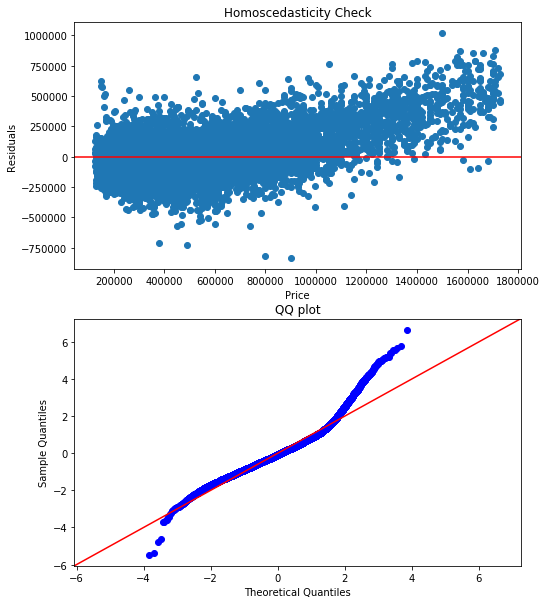

In [141]:
ModelCheck(X_train, y_train, X_test, y_test)

Third Model Summary:

Adj.R-squared = 0.675

Average Error = ~150,000

There was really no change even though we were able to discard two features.


## Scaling features

Scaling features that do not seem to have a normal distribution.

In [142]:
df_linear.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
       'view', 'condition', 'grade', 'Renovated',
       'DistanceFromCenterOfSeattle'],
      dtype='object')

In [145]:
continuous_features = ['bathrooms','bedrooms','condition','sqft_living',
                       'DistanceFromCenterOfSeattle']
len(continuous_features)

5

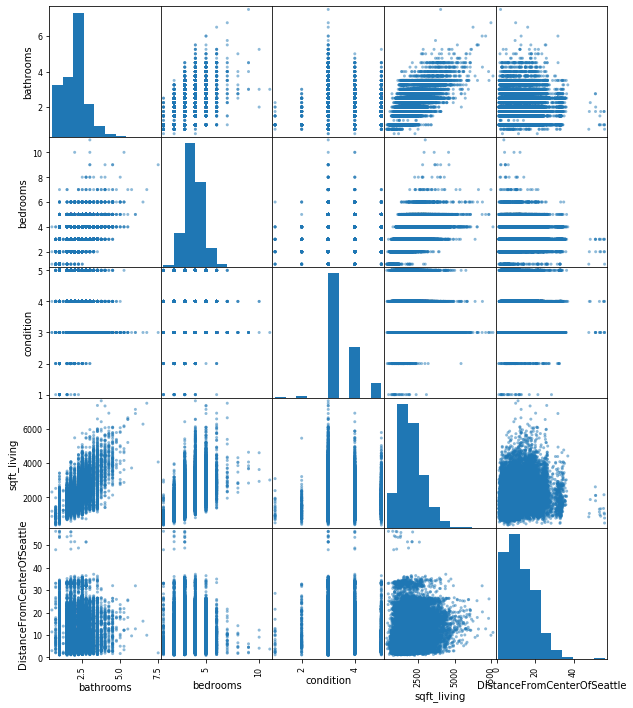

In [146]:
pd.plotting.scatter_matrix(df_linear[continuous_features], figsize=(10,12));

In [147]:
Log_transform=['sqft_living','DistanceFromCenterOfSeattle']
for feature in Log_transform:
    X_train[feature] = X_train[feature].map(lambda x: np.log(x))
    X_test[feature] = X_test[feature].map(lambda x: np.log(x))

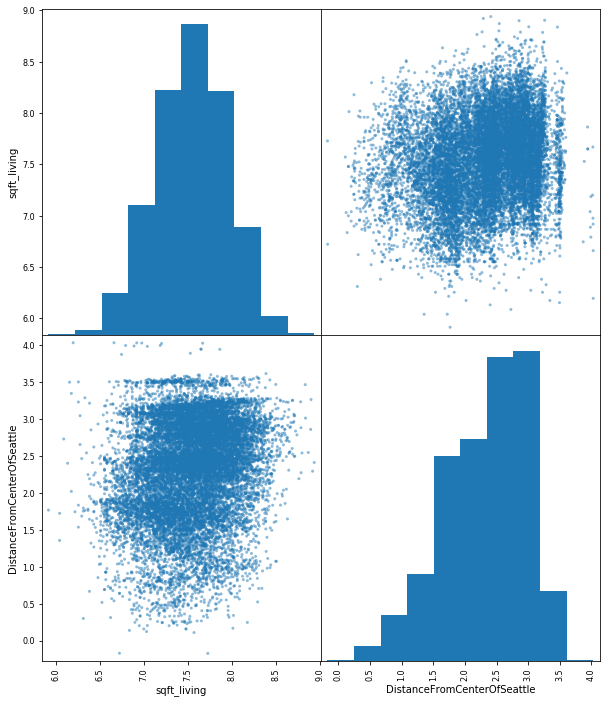

In [148]:
pd.plotting.scatter_matrix(X_train[Log_transform], figsize=(10,12));

The features that were scaled were sqft_living and DistanceFromCenterOfSeattle.

## Fourth Model using scaled features

{'Lagrange multiplier statistic': 1255.131036563538, 'p-value': 1.1712836659767085e-265, 'f-value': 169.34893340292865, 'f p-value': 3.974647121049684e-276}
Train Mean Squarred Error: 24400497376.551594
Test Mean Squarred Error: 23508844287.6662
Train Mean Error: 156206.58557356536
Test Mean Error: 153325.94133957307
Difference in Mean Error: -2880.644233992294


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     4110.
Date:                Sun, 01 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:04:47   Log-Likelihood:            -2.2674e+05
No. Observations:               16949   AIC:                         4.535e+05
Df Residuals:                   16940   BIC:                         4.536e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -1.949e+06      3e+04    -65.033      0.000   -2.01e+06   -1.89e+06
view                          4.27e+04   1825.945     23.387      0.000    3.91e+04    4.63e+04
bedrooms                    -9533.7220   1769.277     -5.388      0.000    -1.3e+04   -6065.755
DistanceFromCenterOfSeattle -1.393e+05   1876.957    -74.195      0.000   -1.43e+05   -1.36e+05
grade                        1.044e+05   1625.787     64.212      0.000    1.01e+05    1.08e+05
sqft_living                  2.467e+05   5365.756     45.977      0.000    2.36e+05    2.57e+05
condition                    4.361e+04   1889.620     23.076      0.000    3.99e+04    4.73e+04
Renovated_1                   8.41e+04   6693.897     12.564      0.000     7.1e+04    9.72e+04
waterfront_1.0               2.298e+05   1.98e+04     11.588      0.000    1.91e+05    2.69e+05
==============================================================================
Omnibus:                     2912.868   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7841.633
Skew:                           0.934   Prob(JB):                         0.00
Kurtosis:                       5.760   Cond. No.                         306.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

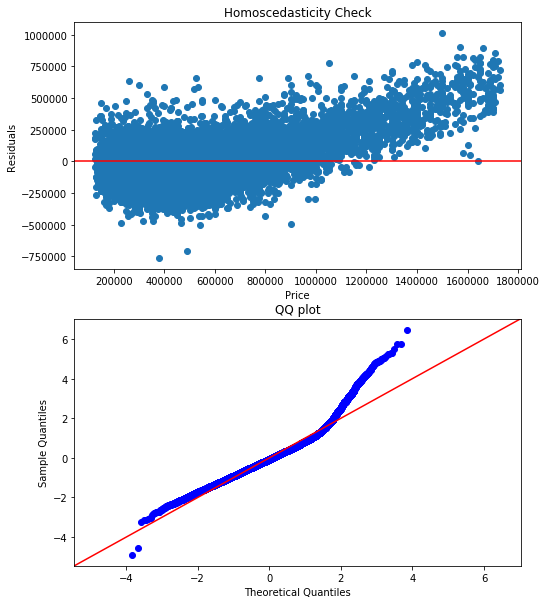

In [149]:
ModelCheck(X_train, y_train, X_test, y_test)

Fourth Model Summary:

Adj.R-squared = 0.660

Average Error = ~155,000

The model actually seemed to get a little worse, the R-squared went down and the error went up.


## Fifth Model, dropping features

Decided to drop bedrooms since there was a negative coefficient for it. It seems weird that the increase in bedrooms would drop the price.

In [150]:
X_train = X_train.drop(['bedrooms'],axis=1)
X_test = X_test.drop(['bedrooms'],axis=1)

{'Lagrange multiplier statistic': 1242.2549641321264, 'p-value': 5.139091413804489e-264, 'f-value': 191.41040816089765, 'f p-value': 2.791821035198321e-274}
Train Mean Squarred Error: 24442320714.99975
Test Mean Squarred Error: 23637037904.875996
Train Mean Error: 156340.40013700793
Test Mean Error: 153743.41580983557
Difference in Mean Error: -2596.9843271723657


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     4685.
Date:                Sun, 01 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:07:39   Log-Likelihood:            -2.2676e+05
No. Observations:               16949   AIC:                         4.535e+05
Df Residuals:                   16941   BIC:                         4.536e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -1.866e+06   2.57e+04    -72.497      0.000   -1.92e+06   -1.82e+06
view                         4.341e+04   1822.754     23.815      0.000    3.98e+04     4.7e+04
DistanceFromCenterOfSeattle  -1.39e+05   1877.982    -74.027      0.000   -1.43e+05   -1.35e+05
grade                        1.061e+05   1596.863     66.428      0.000    1.03e+05    1.09e+05
sqft_living                  2.299e+05   4364.408     52.665      0.000    2.21e+05    2.38e+05
condition                    4.317e+04   1889.476     22.849      0.000    3.95e+04    4.69e+04
Renovated_1                  8.464e+04   6698.696     12.635      0.000    7.15e+04    9.78e+04
waterfront_1.0               2.327e+05   1.98e+04     11.730      0.000    1.94e+05    2.72e+05
==============================================================================
Omnibus:                     2888.875   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7721.177
Skew:                           0.929   Prob(JB):                         0.00
Kurtosis:                       5.735   Cond. No.                         251.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

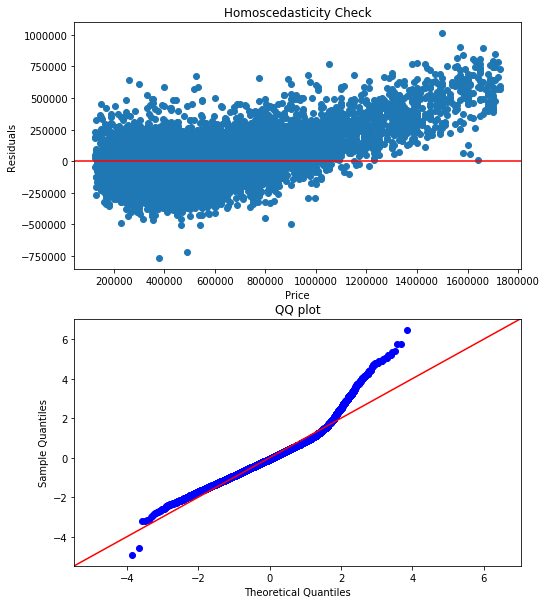

In [151]:
ModelCheck(X_train, y_train, X_test, y_test)

Fifth Model Summary:

Adj.R-squared = 0.659

Average Error = ~155,000

There seems like there was really no change even though we discarded bedrooms.


## Sixth Model using scaled dependent value

Decided to scale price to see if we can get a better model.

In [152]:
y_log_train = y_train.apply(lambda x: np.log(x))
y_log_test = y_test.apply(lambda x: np.log(x))

{'Lagrange multiplier statistic': 332.69033423440413, 'p-value': 6.233008112312795e-68, 'f-value': 48.455893771450334, 'f p-value': 1.289082469485719e-68}
Train Mean Squarred Error: 21710459668.07786
Test Mean Squarred Error: 21143896936.242123
Train Mean Error: 147344.69677622558
Test Mean Error: 145409.411443146
Difference in Mean Error: -1935.285333079577


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     4986.
Date:                Sun, 01 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:09:09   Log-Likelihood:                -2197.4
No. Observations:               16949   AIC:                             4411.
Df Residuals:                   16941   BIC:                             4473.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           8.4311      0.045    185.917      0.000       8.342       8.520
view                            0.0510      0.003     15.880      0.000       0.045       0.057
DistanceFromCenterOfSeattle    -0.2778      0.003    -83.961      0.000      -0.284      -0.271
grade                           0.1724      0.003     61.262      0.000       0.167       0.178
sqft_living                     0.4878      0.008     63.436      0.000       0.473       0.503
condition                       0.0691      0.003     20.751      0.000       0.063       0.076
Renovated_1                     0.1143      0.012      9.683      0.000       0.091       0.137
waterfront_1.0                  0.3434      0.035      9.825      0.000       0.275       0.412
==============================================================================
Omnibus:                       42.982   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.944
Skew:                          -0.003   Prob(JB):                     1.17e-12
Kurtosis:                       3.279   Cond. No.                         251.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

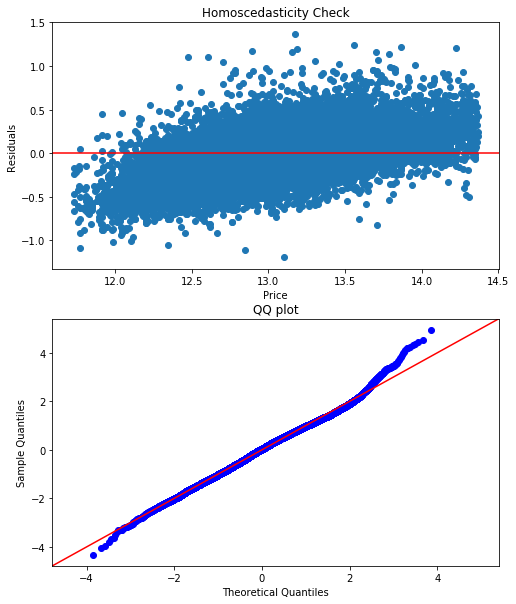

In [153]:
LoggedModelCheck(X_train,y_log_train,X_test,y_log_test)

Sixth Model Summary:

Adj.R-squared = 0.673

Average Error = ~145,000

With the scaled dependent value we were able to get the qq-plot to look much better,  raise the R-squared and also decrease the error.

## Setting up zipcodes for seventh model

Decided to go back and try adding zipcodes because location is important. This did not have a linear trend with price but that is probably due to the fact that it is a categorical variable.

In [160]:
testdrop = ['sqft_lot','yr_built','yr_renovated','sqft_lot15',
            'Age_When_Sold','Age_Since_Renovation','Renovated*Age',
            'sqft_living15','sqft_above','sqft_basement','bedrooms']

df_test_zip = df.drop(testdrop,axis=1)

Log_transform=['sqft_living','DistanceFromCenterOfSeattle']

for feature in Log_transform:
    df_test_zip[feature] = df_test_zip[feature].map(lambda x: np.log(x))



In [161]:
#Creating Dummie Variables 
dummy_list_zip = ['Renovated','waterfront','zipcode'] #Trying grade as a continuous variable, Also try without zipcode
dum=df_test_zip[dummy_list_zip].astype('category')
dummies = pd.get_dummies(dum[dummy_list_zip],prefix=dummy_list_zip,drop_first=True)
df_preprocessed = df_test_zip.drop(dummy_list_zip, axis=1)
df_preprocessed = pd.concat([df_preprocessed,dummies],axis=1)

In [162]:
y_zipcode = df_preprocessed['price']
X_zipcode = df_preprocessed.drop(['price'],axis=1)

X_zipcode_train, X_zipcode_test, y_zipcode_train, y_zipcode_test = train_test_split(X_zipcode, y_zipcode, test_size=0.2)


In [163]:
results_zip = stepwise_selection(X_zipcode_train,y_zipcode_train)

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  sqft_living                    with p-value 0.0
Add  DistanceFromCenterOfSeattle    with p-value 0.0
Add  grade                          with p-value 0.0
Add  zipcode_98004                  with p-value 1.09815e-251
Add  view                           with p-value 2.20401e-232
Add  zipcode_98040                  with p-value 9.15808e-127
Add  zipcode_98033                  with p-value 1.03358e-94
Add  condition                      with p-value 2.19323e-81
Add  zipcode_98053                  with p-value 1.60671e-71
Add  zipcode_98039                  with p-value 2.28399e-68
Add  zipcode_98023                  with p-value 1.19885e-51
Add  zipcode_98105                  with p-value 9.19638e-52
Add  zipcode_98112                  with p-value 1.48486e-55
Add  waterfront_1.0                 with p-value 1.04902e-50
Add  zipcode_98115                  with p-value 3.47645e-49
Add  zipcode_98117                  with p-value 2.08609e-49
Add  zipcode_98006                  with p-va

In [164]:
X_zipcode_train=X_zipcode_train[results_zip]
X_zipcode_test=X_zipcode_test[results_zip]

In [165]:
y_log_zip_train = y_zipcode_train.apply(lambda x: np.log(x))
y_log_zip_test = y_zipcode_test.apply(lambda x: np.log(x))

## Seventh Model, using zipcodes

{'Lagrange multiplier statistic': 863.4767986412232, 'p-value': 7.4948595837235e-140, 'f-value': 13.94285609772904, 'f p-value': 4.4730780656270657e-144}
Train Mean Squarred Error: 10740620061.631554
Test Mean Squarred Error: 10858732114.72424
Train Mean Error: 103636.96281554933
Test Mean Error: 104205.24034195323
Difference in Mean Error: 568.2775264039083


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     1557.
Date:                Sun, 01 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:23:08   Log-Likelihood:                 4760.3
No. Observations:               16949   AIC:                            -9389.
Df Residuals:                   16883   BIC:                            -8878.
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           8.6202      0.040    215.707      0.000       8.542       8.699
sqft_living                     0.4600      0.006     74.260      0.000       0.448       0.472
DistanceFromCenterOfSeattle    -0.1731      0.006    -30.582      0.000      -0.184      -0.162
grade                           0.1139      0.002     54.538      0.000       0.110       0.118
zipcode_98004                   0.8797      0.014     61.732      0.000       0.852       0.908
view                            0.0658      0.002     29.425      0.000       0.061       0.070
zipcode_98040                   0.6571      0.014     46.417      0.000       0.629       0.685
zipcode_98033                   0.6068      0.011     56.225      0.000       0.586       0.628
condition                       0.0489      0.002     20.826      0.000       0.044       0.054
zipcode_98053                   0.5722      0.011     52.508      0.000       0.551       0.594
zipcode_98039                   1.0330      0.042     24.314      0.000       0.950       1.116
zipcode_98023                  -0.0700      0.010     -7.042      0.000      -0.089      -0.051
zipcode_98105                   0.6215      0.016     39.830      0.000       0.591       0.652
zipcode_98112                   0.5760      0.017     34.230      0.000       0.543       0.609
waterfront_1.0                  0.4084      0.024     17.104      0.000       0.362       0.455
zipcode_98115                   0.5252      0.010     50.556      0.000       0.505       0.546
zipcode_98117                   0.5294      0.010     50.994      0.000       0.509       0.550
zipcode_98006                   0.4812      0.010     46.488      0.000       0.461       0.501
zipcode_98052                   0.5143      0.009     55.584      0.000       0.496       0.532
zipcode_98075                   0.5346      0.012     45.742      0.000       0.512       0.558
zipcode_98103                   0.4896      0.011     45.210      0.000       0.468       0.511
zipcode_98199                   0.5141      0.014     36.765      0.000       0.487       0.541
zipcode_98119                   0.5539      0.018     30.873      0.000       0.519       0.589
zipcode_98005                   0.5694      0.017     33.932      0.000       0.536       0.602
zipcode_98074                   0.4868      0.011     45.933      0.000       0.466       0.508
zipcode_98029                   0.5317      0.012     44.084      0.000       0.508       0.555
zipcode_98027                   0.4648      0.011     42.077      0.000       0.443       0.486
zipcode_98008                   0.4935      0.012     39.554      0.000       0.469       0.518
zipcode_98065                   0.4424      0.013     35.323      0.000       0.418       0.467
zipcode_981

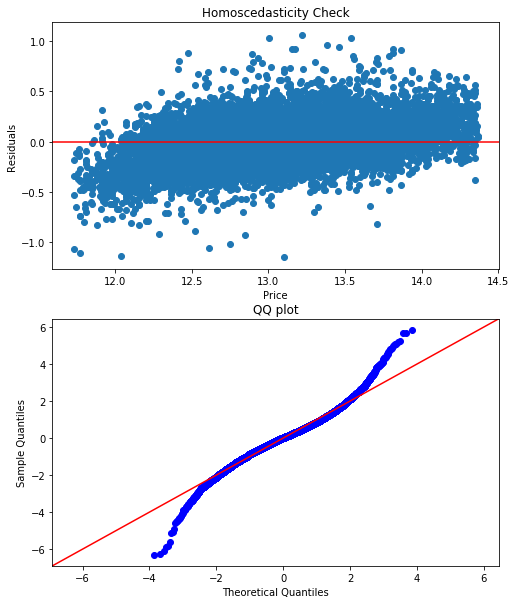

In [166]:
LoggedModelCheck(X_zipcode_train, y_log_zip_train, X_zipcode_test,y_log_zip_test)

Seventh Model Summary:

Adj.R-squared = 0.856

Average Error = ~100,000

Adding Zipcodes was a significant improvement to the model. The Adj. R-squared rose to 0.856 and the average error in the model lowered to around 100,000. The QQ-plot shows that there is some light tails. 

# Conclusions

In conclusion Linear Regression may not be the best modeling technique to use on predicting housing prices but it did a fairly decent job. The final model has a Adj. R-squared value of 0.856. This means that 85.6% of the variation in price (dependent value) can be accounted by the model. And the average error for the model is $100,000 which is 20% of the average price.

By looking at the Homoscedacisity Plot we can see that the model tends to overpredict values on the lower end of the market and under predict values on the higher end of the market.

The features that were used in the final model is:
1. "zipcode" (categorical)
2. "sqft_living"
3. "DistanceFromCenterOfSeattle"
4. "view"
5. "grade"
6. "Condition"
7. "waterfront" (categorical)
8. "renovated" (categorical)
9. "floors"
10. "bathrooms"

This model is also consistent when working with new data, as show the difference in Mean Error is only ~$550 from the training set and the testing set. 

The future steps I want to take with this model is to look at school districts. I know school districts are important when buying houses and replacing zipcode with these districts might create a more accurate model.

# Future Work

In [57]:
import json

In [58]:
f = open('School_Districts_in_King_County___schdst_area.geojson')
schooldata = json.load(f)
print(type(schooldata))

<class 'dict'>


In [59]:
schooldata.keys()

dict_keys(['type', 'name', 'crs', 'features'])

In [60]:
for v in schooldata.values():
    print(type(v))

<class 'str'>
<class 'str'>
<class 'dict'>
<class 'list'>


In [61]:
schooldatafeatures = schooldata['features']

In [62]:
districtnames=[]
for district in schooldatafeatures:
    districtnames.append(district['properties']['NAME'])

In [63]:
districtnames

['Seattle',
 'Federal Way',
 'Enumclaw',
 'Mercer Island',
 'Highline',
 'Vashon Island',
 'Renton',
 'Skykomish',
 'Bellevue',
 'Tukwila',
 'Riverview',
 'Auburn',
 'Tahoma',
 'Snoqualmie Valley',
 'Issaquah',
 'Shoreline',
 'Lake Washington',
 'Kent',
 'Northshore',
 'Fife']

In [64]:
coordinates = schooldata['features'][0]['geometry']['coordinates']

In [65]:
len(coordinates[0][0])

3838

In [66]:
len(coordinates[1][0])

2169

In [67]:
schoollat=[]
schoollong=[]
for entries in coordinates:
    for nextentry in entries:
        for nextnextentry in nextentry:
            schoollat.append(nextnextentry[0])
            schoollong.append(nextnextentry[1])

In [68]:
np.min(schoollat)

-122.44124758244769

In [69]:
np.max(schoollat)

-122.23600658023713

In [70]:
np.min(schoollong)

47.49523293330664

In [71]:
np.max(schoollong)

47.73416642533758

In [72]:
schooldistrictdf = pd.DataFrame()

In [73]:
schooldistrictdf['Districts'] = districtnames

In [74]:
schooldistrictdf

,Districts
0,Seattle
1,Federal Way
2,Enumclaw
3,Mercer Island
4,Highline
5,Vashon Island
6,Renton
7,Skykomish
8,Bellevue
9,Tukwila


In [75]:
DistrictMinLat = []
DistrictMaxLat = []
DistrictMinLong = []
DistrictMaxLong = []

for i in list(range(len(schooldatafeatures))):
    schoollat=[]
    schoollong=[]
    if len(schooldatafeatures[i]['geometry']['coordinates']) == 2 :
        for entries in schooldatafeatures[i]['geometry']['coordinates']:
            for nextentry in entries:
                for nextnextentry in nextentry:
                    districtlat = (nextnextentry[0])
                    districtlong = (nextnextentry[1])
                    schoollat.append(districtlat)
                    schoollong.append(districtlong)
    if len(schooldatafeatures[i]['geometry']['coordinates']) == 1:
        for entries in schooldatafeatures[i]['geometry']['coordinates']:
            for nextentry in entries:
                districtlat=(nextentry[0])
                districtlong=(nextentry[1])
                schoollat.append(districtlat)
                schoollong.append(districtlong)
    DistrictMinLat.append(np.min(schoollat))
    DistrictMaxLat.append(np.max(schoollat))
    DistrictMinLong.append(np.min(schoollong))
    DistrictMaxLong.append(np.max(schoollong))

In [76]:
DistrictMinLong

[47.49523293330664,
 47.25726486525117,
 47.08486429155255,
 47.52443922428892,
 47.37575900866263,
 47.33063929550873,
 47.429858017221896,
 47.51206069882483,
 47.53772626559033,
 47.445023266738716,
 47.583428207762225,
 47.22824190825748,
 47.313373652201456,
 47.33929024250949,
 47.42914252079446,
 47.733741997151604,
 47.601365153201414,
 47.30124592536611,
 47.71115073019409,
 47.25720535555588]

In [77]:
schooldistrictdf['DistrictMinLat'] = DistrictMinLat
schooldistrictdf['DistrictMaxLat'] = DistrictMaxLat
schooldistrictdf['DistrictMinLong'] = DistrictMinLong
schooldistrictdf['DistrictMaxLong'] = DistrictMaxLong

In [78]:
schooldistrictdf

,Districts,DistrictMinLat,DistrictMaxLat,DistrictMinLong,DistrictMaxLong
0,Seattle,-122.441248,-122.236007,47.495233,47.734166
1,Federal Way,-122.417716,-122.249792,47.257265,47.393900
2,Enumclaw,-122.117719,-121.297778,47.084864,47.387173
3,Mercer Island,-122.254506,-122.201586,47.524439,47.596037
4,Highline,-122.382935,-122.264172,47.375759,47.517426
5,Vashon Island,-122.528504,-122.373769,47.330639,47.511185
6,Renton,-122.272747,-122.111996,47.429858,47.549428
7,Skykomish,-121.598509,-121.064280,47.512061,47.780576
8,Bellevue,-122.243221,-122.086939,47.537726,47.653461
9,Tukwila,-122.297609,-122.242633,47.445023,47.510177


In [97]:
schooldistrictdf.set_index('Districts',inplace=True)
schooldistrictdict = schooldistrictdf.to_dict('index')

In [98]:
schooldistrictdict

{'Seattle': {'DistrictMinLat': -122.44124758244769,
  'DistrictMaxLat': -122.23600658023713,
  'DistrictMinLong': 47.49523293330664,
  'DistrictMaxLong': 47.73416642533758},
 'Federal Way': {'DistrictMinLat': -122.41771577355097,
  'DistrictMaxLat': -122.2497920085449,
  'DistrictMinLong': 47.25726486525117,
  'DistrictMaxLong': 47.39389966443558},
 'Enumclaw': {'DistrictMinLat': -122.11771853316172,
  'DistrictMaxLat': -121.29777841573559,
  'DistrictMinLong': 47.08486429155255,
  'DistrictMaxLong': 47.38717303415077},
 'Mercer Island': {'DistrictMinLat': -122.25450649387167,
  'DistrictMaxLat': -122.20158608160529,
  'DistrictMinLong': 47.52443922428892,
  'DistrictMaxLong': 47.59603700537001},
 'Highline': {'DistrictMinLat': -122.38293468674208,
  'DistrictMaxLat': -122.2641719537248,
  'DistrictMinLong': 47.37575900866263,
  'DistrictMaxLong': 47.51742558175619},
 'Vashon Island': {'DistrictMinLat': -122.5285041958344,
  'DistrictMaxLat': -122.37376929325252,
  'DistrictMinLong': 4

In [ ]:
for k,v in schooldistrictdict:
    df[k] = 